In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e1-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e1-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
sample_range = range(800, 1000)

Sparse Bayesian Learning (SBL)

In [17]:
def sbl_algorithm(A, y, N, sig2e, Tau_p, loc, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = A @ Gamma @ A.conj().T + sig2e * np.eye(Tau_p)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ A.conj().T @ Sigma_y_inv @ A @ Gamma
        mu_x = Gamma @ A.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [18]:
# Placeholder arrays for SBL results
z_sbl = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # SBL results
gamma_sbl = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # SBL gamma values
hit_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Hit rate for SBL
support_recovery_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Miss detection rate for SBL
false_alarm_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # False alarm rate for SBL
norm_mse_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Norm MSE for SBL

In [19]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_sbl[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_sbl[sample_index, pilot_length_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for SBL
        hit_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the support recovery rate for sbl
        support_recovery_rate_sbl[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool ==1) & (gamma == 1))
            /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Calculate the false alarm rate for SBL
        false_alarm_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for SBL
        norm_mse_sbl[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )  # Avoid division by zero


Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.63s/it]

Converged after 363 iterations



Processing Samples:   0%|          | 1/200 [01:25<4:42:12, 85.09s/it]

Converged after 409 iterations



Processing Samples:   1%|          | 2/200 [02:48<4:36:43, 83.85s/it]

Converged after 407 iterations



Processing Samples:   2%|▏         | 3/200 [04:07<4:28:52, 81.89s/it]

Converged after 430 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.43s/it]

Converged after 409 iterations



Processing Samples:   2%|▏         | 4/200 [05:26<4:23:26, 80.65s/it]

Converged after 332 iterations



Processing Samples:   2%|▎         | 5/200 [06:45<4:20:01, 80.01s/it]

Converged after 402 iterations



Processing Samples:   3%|▎         | 6/200 [08:05<4:19:12, 80.17s/it]

Converged after 341 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:26, 13.13s/it]

Converged after 463 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.47s/it]

Converged after 474 iterations



Processing Samples:   4%|▎         | 7/200 [09:20<4:12:39, 78.54s/it]

Converged after 297 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.10s/it]

Converged after 423 iterations



Processing Samples:   4%|▍         | 8/200 [10:38<4:10:15, 78.21s/it]

Converged after 415 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.78s/it]

Converged after 460 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.49s/it]

Converged after 394 iterations



Processing Samples:   5%|▌         | 10/200 [13:16<4:08:02, 78.33s/it]

Converged after 359 iterations



Processing Samples:   6%|▌         | 11/200 [14:39<4:10:40, 79.58s/it]

Converged after 425 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:12, 12.81s/it]

Converged after 379 iterations



Processing Samples:   6%|▌         | 12/200 [15:55<4:06:39, 78.72s/it]

Converged after 441 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.82s/it]

Converged after 465 iterations



Processing Samples:   7%|▋         | 14/200 [18:36<4:05:53, 79.32s/it]

Converged after 350 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.16s/it]

Converged after 425 iterations



Processing Samples:   8%|▊         | 15/200 [19:54<4:02:52, 78.77s/it]

Converged after 434 iterations



Processing Samples:   8%|▊         | 16/200 [21:17<4:05:37, 80.09s/it]

Converged after 464 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.57s/it]

Converged after 436 iterations



Processing Samples:   8%|▊         | 17/200 [22:34<4:01:32, 79.19s/it]

Converged after 392 iterations



Processing Samples:   9%|▉         | 18/200 [23:54<4:00:50, 79.40s/it]

Converged after 333 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:13, 13.25s/it]

Converged after 489 iterations



Processing Samples:  10%|▉         | 19/200 [25:10<3:57:00, 78.57s/it]

Converged after 336 iterations



Processing Samples:  10%|█         | 20/200 [26:31<3:57:34, 79.19s/it]

Converged after 354 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.38s/it]

Converged after 442 iterations



Processing Samples:  10%|█         | 21/200 [27:50<3:55:30, 78.94s/it]

Converged after 436 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.73s/it]

Converged after 455 iterations



Processing Samples:  11%|█         | 22/200 [29:05<3:51:23, 78.00s/it]

Converged after 328 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.35s/it]

Converged after 402 iterations



Processing Samples:  12%|█▏        | 23/200 [30:26<3:52:52, 78.94s/it]

Converged after 454 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.21s/it]

Converged after 455 iterations



Processing Samples:  12%|█▎        | 25/200 [33:10<3:54:11, 80.30s/it]

Converged after 466 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:12, 12.52s/it]

Converged after 326 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.50s/it]

Converged after 459 iterations



Processing Samples:  14%|█▎        | 27/200 [35:50<3:51:14, 80.20s/it]

Converged after 495 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.89s/it]

Converged after 466 iterations



Processing Samples:  14%|█▍        | 28/200 [37:13<3:51:45, 80.84s/it]

Converged after 442 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:01<00:11, 11.49s/it]

Converged after 326 iterations



Processing Samples:  14%|█▍        | 29/200 [38:27<3:44:54, 78.91s/it]

Converged after 394 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:27, 13.59s/it]

Converged after 472 iterations



Processing Samples:  15%|█▌        | 30/200 [39:43<3:41:03, 78.02s/it]

Converged after 317 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.63s/it]

Converged after 445 iterations



Processing Samples:  16%|█▌        | 31/200 [41:04<3:41:59, 78.81s/it]

Converged after 405 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:25, 12.62s/it]

Converged after 482 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:12, 12.42s/it]

Converged after 388 iterations



Processing Samples:  16%|█▌        | 32/200 [42:19<3:37:23, 77.64s/it]

Converged after 381 iterations



Processing Samples:  16%|█▋        | 33/200 [43:39<3:37:54, 78.29s/it]

Converged after 385 iterations



Processing Samples:  17%|█▋        | 34/200 [44:59<3:38:13, 78.87s/it]

Converged after 405 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.71s/it]

Converged after 486 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.43s/it]

Converged after 424 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:13, 13.63s/it]

Converged after 470 iterations



Processing Samples:  18%|█▊        | 36/200 [47:38<3:36:09, 79.08s/it]

Converged after 353 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.70s/it]

Converged after 400 iterations



Processing Samples:  19%|█▉        | 38/200 [50:18<3:33:23, 79.03s/it]

Converged after 361 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:14, 14.14s/it]

Converged after 499 iterations



Processing Samples:  20%|█▉        | 39/200 [51:40<3:34:45, 80.03s/it]

Converged after 412 iterations



Processing Samples:  20%|██        | 40/200 [53:00<3:32:58, 79.87s/it]

Converged after 436 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.50s/it]

Converged after 468 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:01<00:11, 11.36s/it]

Converged after 333 iterations



Processing Samples:  20%|██        | 41/200 [54:14<3:27:20, 78.24s/it]

Converged after 417 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.53s/it]

Converged after 431 iterations



Processing Samples:  21%|██        | 42/200 [55:32<3:26:06, 78.27s/it]

Converged after 337 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.99s/it]

Converged after 386 iterations



Processing Samples:  22%|██▏       | 43/200 [56:49<3:23:49, 77.89s/it]

Converged after 407 iterations



Processing Samples:  22%|██▎       | 45/200 [59:31<3:23:53, 78.92s/it]

Converged after 312 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.24s/it]

Converged after 455 iterations



Processing Samples:  24%|██▎       | 47/200 [1:02:14<3:24:21, 80.14s/it]

Converged after 450 iterations



Processing Samples:  24%|██▍       | 48/200 [1:03:37<3:25:19, 81.05s/it]

Converged after 457 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.93s/it]

Converged after 475 iterations



Processing Samples:  24%|██▍       | 49/200 [1:05:00<3:24:49, 81.39s/it]

Converged after 458 iterations



Processing Samples:  25%|██▌       | 50/200 [1:06:17<3:20:08, 80.06s/it]

Converged after 292 iterations



Processing Samples:  26%|██▌       | 51/200 [1:07:35<3:17:29, 79.53s/it]

Converged after 385 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:12, 12.96s/it]

Converged after 360 iterations



Processing Samples:  26%|██▌       | 52/200 [1:08:52<3:14:13, 78.74s/it]

Converged after 342 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:51<00:26, 13.34s/it]

Converged after 491 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:13, 13.46s/it]

Converged after 451 iterations



Processing Samples:  26%|██▋       | 53/200 [1:10:10<3:12:26, 78.55s/it]

Converged after 409 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:01<00:11, 11.50s/it]

Converged after 331 iterations



Processing Samples:  27%|██▋       | 54/200 [1:11:23<3:07:33, 77.08s/it]

Converged after 364 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:14, 14.00s/it]

Converged after 488 iterations



Processing Samples:  28%|██▊       | 55/200 [1:12:46<3:10:29, 78.83s/it]

Converged after 457 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:25, 12.76s/it]

Converged after 493 iterations



Processing Samples:  28%|██▊       | 56/200 [1:14:06<3:10:00, 79.17s/it]

Converged after 475 iterations



Processing Samples:  28%|██▊       | 57/200 [1:15:27<3:09:44, 79.61s/it]

Converged after 353 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:12, 12.49s/it]

Converged after 444 iterations



Processing Samples:  29%|██▉       | 58/200 [1:16:42<3:05:25, 78.35s/it]

Converged after 327 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.31s/it]

Converged after 405 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.11s/it]

Converged after 429 iterations



Processing Samples:  30%|███       | 60/200 [1:19:20<3:02:47, 78.34s/it]

Converged after 350 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:52<00:26, 13.09s/it]

Converged after 455 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:01<00:11, 11.77s/it]

Converged after 384 iterations



Processing Samples:  30%|███       | 61/200 [1:20:35<2:58:49, 77.19s/it]

Converged after 391 iterations



Processing Samples:  31%|███       | 62/200 [1:21:51<2:57:15, 77.07s/it]

Converged after 324 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.87s/it]

Converged after 469 iterations



Processing Samples:  32%|███▏      | 63/200 [1:23:13<2:58:59, 78.39s/it]

Converged after 421 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.73s/it]

Converged after 453 iterations



Processing Samples:  32%|███▏      | 64/200 [1:24:31<2:57:29, 78.30s/it]

Converged after 427 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.95s/it]

Converged after 488 iterations



Processing Samples:  32%|███▎      | 65/200 [1:25:53<2:58:51, 79.49s/it]

Converged after 441 iterations



Processing Samples:  33%|███▎      | 66/200 [1:27:17<3:00:25, 80.79s/it]

Converged after 483 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:49<00:25, 12.63s/it]

Converged after 436 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:00<00:11, 11.91s/it]

Converged after 319 iterations



Processing Samples:  34%|███▎      | 67/200 [1:28:29<2:53:26, 78.25s/it]

Converged after 364 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:13, 13.04s/it]

Converged after 411 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:51<00:25, 12.84s/it]

Converged after 389 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:00<00:11, 11.30s/it]

Converged after 374 iterations



Processing Samples:  35%|███▌      | 70/200 [1:32:28<2:52:09, 79.46s/it]

Converged after 480 iterations



Processing Samples:  36%|███▌      | 71/200 [1:33:52<2:53:37, 80.76s/it]

Converged after 481 iterations



Processing Samples:  36%|███▌      | 72/200 [1:35:09<2:50:06, 79.74s/it]

Converged after 356 iterations



Processing Samples:  36%|███▋      | 73/200 [1:36:28<2:48:01, 79.38s/it]

Converged after 312 iterations



Processing Samples:  37%|███▋      | 74/200 [1:37:47<2:46:37, 79.35s/it]

Converged after 370 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.83s/it]

Converged after 465 iterations



Processing Samples:  38%|███▊      | 75/200 [1:39:04<2:43:44, 78.59s/it]

Converged after 360 iterations



Processing Samples:  38%|███▊      | 76/200 [1:40:26<2:44:22, 79.54s/it]

Converged after 392 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.36s/it]

Converged after 420 iterations



Processing Samples:  38%|███▊      | 77/200 [1:41:45<2:42:36, 79.32s/it]

Converged after 488 iterations



Processing Samples:  39%|███▉      | 78/200 [1:43:08<2:43:44, 80.53s/it]

Converged after 463 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.49s/it]

Converged after 424 iterations



Processing Samples:  40%|███▉      | 79/200 [1:44:24<2:40:00, 79.34s/it]

Converged after 385 iterations



Processing Samples:  40%|████      | 80/200 [1:45:48<2:41:01, 80.52s/it]

Converged after 455 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:11, 11.89s/it]

Converged after 370 iterations



Processing Samples:  41%|████      | 82/200 [1:48:27<2:36:21, 79.51s/it]

Converged after 337 iterations



Processing Samples:  42%|████▏     | 83/200 [1:49:48<2:36:15, 80.13s/it]

Converged after 414 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.26s/it]

Converged after 419 iterations



Processing Samples:  42%|████▏     | 84/200 [1:51:04<2:32:40, 78.97s/it]

Converged after 352 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:51<00:25, 12.62s/it]

Converged after 490 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:12, 12.88s/it]

Converged after 458 iterations



Processing Samples:  42%|████▎     | 85/200 [1:52:22<2:30:31, 78.54s/it]

Converged after 406 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:14, 14.12s/it]

Converged after 495 iterations



Processing Samples:  43%|████▎     | 86/200 [1:53:45<2:31:36, 79.80s/it]

Converged after 436 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:14, 14.09s/it]

Converged after 494 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:49<00:25, 12.69s/it]

Converged after 430 iterations



Processing Samples:  44%|████▍     | 88/200 [1:56:28<2:30:10, 80.45s/it]

Converged after 455 iterations



Processing Samples:  44%|████▍     | 89/200 [1:57:51<2:30:19, 81.25s/it]

Converged after 443 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:51<00:26, 13.33s/it]

Converged after 491 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:12, 12.65s/it]

Converged after 354 iterations



Processing Samples:  46%|████▌     | 91/200 [2:00:29<2:24:25, 79.50s/it]

Converged after 302 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:51<00:26, 13.23s/it]

Converged after 500 iterations



Processing Samples:  46%|████▌     | 92/200 [2:01:49<2:23:24, 79.67s/it]

Converged after 441 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.60s/it]

Converged after 425 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.84s/it]

Converged after 463 iterations



Processing Samples:  47%|████▋     | 94/200 [2:04:29<2:20:43, 79.65s/it]

Converged after 368 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.30s/it]

Converged after 401 iterations



Processing Samples:  48%|████▊     | 95/200 [2:05:48<2:19:19, 79.61s/it]

Converged after 391 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.13s/it]

Converged after 426 iterations



Processing Samples:  48%|████▊     | 96/200 [2:07:05<2:16:34, 78.80s/it]

Converged after 387 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.59s/it]

Converged after 434 iterations



Processing Samples:  48%|████▊     | 97/200 [2:08:22<2:14:00, 78.06s/it]

Converged after 360 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:14, 14.05s/it]

Converged after 494 iterations



Processing Samples:  49%|████▉     | 98/200 [2:09:44<2:14:40, 79.22s/it]

Converged after 412 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.58s/it]

Converged after 462 iterations



Processing Samples:  50%|█████     | 100/200 [2:12:24<2:12:23, 79.44s/it]

Converged after 317 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.83s/it]

Converged after 458 iterations



Processing Samples:  50%|█████     | 101/200 [2:13:41<2:09:50, 78.69s/it]

Converged after 361 iterations



Processing Samples:  51%|█████     | 102/200 [2:15:05<2:10:54, 80.15s/it]

Converged after 473 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.70s/it]

Converged after 453 iterations



Processing Samples:  52%|█████▏    | 103/200 [2:16:21<2:07:49, 79.06s/it]

Converged after 359 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.73s/it]

Converged after 451 iterations



Processing Samples:  52%|█████▏    | 104/200 [2:17:42<2:07:18, 79.57s/it]

Converged after 397 iterations



Processing Samples:  52%|█████▎    | 105/200 [2:18:59<2:04:45, 78.80s/it]

Converged after 328 iterations



Processing Samples:  53%|█████▎    | 106/200 [2:20:22<2:05:33, 80.15s/it]

Converged after 455 iterations



Processing Samples:  54%|█████▎    | 107/200 [2:21:46<2:05:54, 81.23s/it]

Converged after 476 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.18s/it]

Converged after 432 iterations



Processing Samples:  54%|█████▍    | 108/200 [2:23:03<2:02:52, 80.13s/it]

Converged after 414 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.73s/it]

Converged after 452 iterations



Processing Samples:  55%|█████▍    | 109/200 [2:24:24<2:01:48, 80.32s/it]

Converged after 395 iterations



Processing Samples:  55%|█████▌    | 110/200 [2:25:45<2:00:45, 80.50s/it]

Converged after 490 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:12, 12.72s/it]

Converged after 327 iterations



Processing Samples:  56%|█████▌    | 111/200 [2:27:03<1:58:09, 79.66s/it]

Converged after 399 iterations



Processing Samples:  56%|█████▌    | 112/200 [2:28:22<1:56:37, 79.51s/it]

Converged after 394 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.79s/it]

Converged after 497 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.11s/it]

Converged after 377 iterations



Processing Samples:  56%|█████▋    | 113/200 [2:29:40<1:54:26, 78.92s/it]

Converged after 471 iterations



Processing Samples:  57%|█████▋    | 114/200 [2:31:01<1:54:10, 79.66s/it]

Converged after 382 iterations



Processing Samples:  57%|█████▊    | 115/200 [2:32:20<1:52:31, 79.43s/it]

Converged after 415 iterations



Processing Samples:  58%|█████▊    | 116/200 [2:33:42<1:52:26, 80.31s/it]

Converged after 411 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:11, 11.99s/it]

Converged after 384 iterations



Processing Samples:  58%|█████▊    | 117/200 [2:35:00<1:50:00, 79.52s/it]

Converged after 462 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.22s/it]

Converged after 377 iterations



Processing Samples:  59%|█████▉    | 118/200 [2:36:22<1:49:40, 80.25s/it]

Converged after 490 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:24, 12.36s/it]

Converged after 427 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:12, 12.80s/it]

Converged after 487 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:51<00:26, 13.30s/it]

Converged after 475 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.30s/it]

Converged after 440 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 14.00s/it]

Converged after 478 iterations



Processing Samples:  60%|██████    | 121/200 [2:40:22<1:44:53, 79.66s/it]

Converged after 353 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.93s/it]

Converged after 476 iterations



Processing Samples:  61%|██████    | 122/200 [2:41:42<1:43:41, 79.76s/it]

Converged after 345 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.21s/it]

Converged after 406 iterations



Processing Samples:  62%|██████▏   | 123/200 [2:42:58<1:40:57, 78.67s/it]

Converged after 377 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.92s/it]

Converged after 474 iterations



Processing Samples:  62%|██████▏   | 124/200 [2:44:19<1:40:46, 79.56s/it]

Converged after 402 iterations



Processing Samples:  62%|██████▎   | 125/200 [2:45:40<1:39:53, 79.91s/it]

Converged after 479 iterations



Processing Samples:  63%|██████▎   | 126/200 [2:47:03<1:39:39, 80.80s/it]

Converged after 426 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:12, 12.36s/it]

Converged after 417 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.30s/it]

Converged after 438 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:12, 12.99s/it]

Converged after 401 iterations



Processing Samples:  64%|██████▍   | 128/200 [2:49:41<1:35:45, 79.80s/it]

Converged after 393 iterations



Processing Samples:  64%|██████▍   | 129/200 [2:50:59<1:33:43, 79.20s/it]

Converged after 348 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.24s/it]

Converged after 429 iterations



Processing Samples:  65%|██████▌   | 130/200 [2:52:15<1:31:19, 78.28s/it]

Converged after 347 iterations



Processing Samples:  66%|██████▌   | 131/200 [2:53:36<1:31:10, 79.28s/it]

Converged after 379 iterations



Processing Samples:  66%|██████▌   | 132/200 [2:54:56<1:30:06, 79.51s/it]

Converged after 449 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.02s/it]

Converged after 359 iterations



Processing Samples:  66%|██████▋   | 133/200 [2:56:14<1:28:13, 79.00s/it]

Converged after 344 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:25, 12.93s/it]

Converged after 455 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:13, 13.10s/it]

Converged after 441 iterations



Processing Samples:  67%|██████▋   | 134/200 [2:57:29<1:25:27, 77.68s/it]

Converged after 305 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.69s/it]

Converged after 394 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.55s/it]

Converged after 419 iterations



Processing Samples:  68%|██████▊   | 136/200 [3:00:05<1:22:52, 77.69s/it]

Converged after 299 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:13, 13.25s/it]

Converged after 417 iterations



Processing Samples:  69%|██████▉   | 138/200 [3:02:49<1:22:55, 80.25s/it]

Converged after 475 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:13, 13.66s/it]

Converged after 477 iterations



Processing Samples:  70%|███████   | 140/200 [3:05:31<1:20:09, 80.15s/it]

Converged after 351 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:49<00:23, 11.79s/it]

Converged after 406 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:01<00:11, 11.97s/it]

Converged after 412 iterations



Processing Samples:  70%|███████   | 141/200 [3:06:43<1:16:31, 77.81s/it]

Converged after 312 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.17s/it]

Converged after 405 iterations



Processing Samples:  71%|███████   | 142/200 [3:08:00<1:14:50, 77.42s/it]

Converged after 397 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.39s/it]

Converged after 456 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.44s/it]

Converged after 453 iterations



Processing Samples:  72%|███████▏  | 144/200 [3:10:40<1:13:20, 78.57s/it]

Converged after 391 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.77s/it]

Converged after 500 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.86s/it]

Converged after 470 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:13, 13.61s/it]

Converged after 499 iterations



Processing Samples:  74%|███████▎  | 147/200 [3:14:46<1:10:55, 80.30s/it]

Converged after 379 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.75s/it]

Converged after 485 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.98s/it]

Converged after 484 iterations



Processing Samples:  74%|███████▍  | 148/200 [3:16:09<1:10:18, 81.12s/it]

Converged after 460 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:05<00:13, 13.56s/it]

Converged after 483 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.70s/it]

Converged after 449 iterations



Processing Samples:  75%|███████▌  | 150/200 [3:18:50<1:07:25, 80.92s/it]

Converged after 386 iterations



Processing Samples:  76%|███████▌  | 151/200 [3:20:14<1:06:46, 81.76s/it]

Converged after 455 iterations



Processing Samples:  76%|███████▌  | 152/200 [3:21:34<1:05:01, 81.29s/it]

Converged after 453 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:27, 13.61s/it]

Converged after 471 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.12s/it]

Converged after 389 iterations



Processing Samples:  76%|███████▋  | 153/200 [3:22:48<1:01:50, 78.94s/it]

Converged after 303 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.88s/it]

Converged after 500 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.93s/it]

Converged after 468 iterations



Processing Samples:  77%|███████▋  | 154/200 [3:24:09<1:00:59, 79.56s/it]

Converged after 379 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.66s/it]

Converged after 452 iterations



Processing Samples:  78%|███████▊  | 156/200 [3:26:53<59:21, 80.94s/it]  

Converged after 482 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.82s/it]

Converged after 455 iterations



Processing Samples:  78%|███████▊  | 157/200 [3:28:14<57:58, 80.91s/it]

Converged after 380 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:26, 13.18s/it]

Converged after 475 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:12, 12.71s/it]

Converged after 373 iterations



Processing Samples:  79%|███████▉  | 158/200 [3:29:29<55:21, 79.09s/it]

Converged after 368 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.04s/it]

Converged after 423 iterations



Processing Samples:  80%|███████▉  | 159/200 [3:30:45<53:22, 78.11s/it]

Converged after 344 iterations



Processing Samples:  80%|████████  | 160/200 [3:32:03<51:59, 78.00s/it]

Converged after 350 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.33s/it]

Converged after 439 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.46s/it]

Converged after 454 iterations



Processing Samples:  80%|████████  | 161/200 [3:33:21<50:51, 78.25s/it]

Converged after 352 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:26, 13.09s/it]

Converged after 488 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.26s/it]

Converged after 449 iterations



Processing Samples:  82%|████████▏ | 163/200 [3:36:03<49:10, 79.75s/it]

Converged after 412 iterations



Processing Samples:  82%|████████▏ | 164/200 [3:37:22<47:36, 79.34s/it]

Converged after 379 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.84s/it]

Converged after 465 iterations



Processing Samples:  82%|████████▎ | 165/200 [3:38:43<46:37, 79.94s/it]

Converged after 407 iterations



Processing Samples:  83%|████████▎ | 166/200 [3:40:02<45:06, 79.61s/it]

Converged after 402 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.99s/it]

Converged after 484 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.84s/it]

Converged after 496 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:11, 11.86s/it]

Converged after 366 iterations



Processing Samples:  84%|████████▍ | 168/200 [3:42:42<42:24, 79.53s/it]

Converged after 419 iterations



Processing Samples:  84%|████████▍ | 169/200 [3:44:04<41:21, 80.04s/it]

Converged after 346 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:04<00:13, 13.39s/it]

Converged after 451 iterations



Processing Samples:  85%|████████▌ | 170/200 [3:45:22<39:46, 79.54s/it]

Converged after 421 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:11, 11.94s/it]

Converged after 366 iterations



Processing Samples:  86%|████████▌ | 172/200 [3:48:00<36:47, 78.86s/it]

Converged after 320 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.79s/it]

Converged after 495 iterations



Processing Samples:  86%|████████▋ | 173/200 [3:49:20<35:37, 79.17s/it]

Converged after 407 iterations



Processing Samples:  87%|████████▋ | 174/200 [3:50:41<34:30, 79.64s/it]

Converged after 390 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.76s/it]

Converged after 490 iterations



Processing Samples:  88%|████████▊ | 175/200 [3:52:05<33:44, 80.99s/it]

Converged after 493 iterations



Processing Samples:  88%|████████▊ | 176/200 [3:53:25<32:16, 80.67s/it]

Converged after 441 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.66s/it]

Converged after 441 iterations



Processing Samples:  88%|████████▊ | 177/200 [3:54:45<30:53, 80.57s/it]

Converged after 381 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.77s/it]

Converged after 375 iterations



Processing Samples:  89%|████████▉ | 178/200 [3:56:02<29:05, 79.35s/it]

Converged after 411 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:02<00:11, 11.86s/it]

Converged after 366 iterations



Processing Samples:  90%|████████▉ | 179/200 [3:57:16<27:16, 77.94s/it]

Converged after 352 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.30s/it]

Converged after 393 iterations



Processing Samples:  90%|█████████ | 180/200 [3:58:38<26:19, 78.97s/it]

Converged after 461 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.80s/it]

Converged after 459 iterations



Processing Samples:  91%|█████████ | 182/200 [4:01:21<24:05, 80.28s/it]

Converged after 402 iterations



Processing Samples:  92%|█████████▏| 183/200 [4:02:44<22:57, 81.01s/it]

Converged after 440 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.93s/it]

Converged after 498 iterations



Processing Samples:  92%|█████████▏| 184/200 [4:04:04<21:32, 80.80s/it]

Converged after 427 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.16s/it]

Converged after 397 iterations



Processing Samples:  93%|█████████▎| 186/200 [4:06:46<18:50, 80.72s/it]

Converged after 472 iterations



Processing Samples:  94%|█████████▍| 188/200 [4:09:33<16:22, 81.85s/it]

Converged after 384 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.65s/it]

Converged after 438 iterations



Processing Samples:  95%|█████████▌| 190/200 [4:12:09<13:16, 79.61s/it]

Converged after 279 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:06<00:13, 13.34s/it]

Converged after 404 iterations



Processing Samples:  96%|█████████▌| 191/200 [4:13:29<11:58, 79.83s/it]

Converged after 423 iterations



Processing Samples:  96%|█████████▌| 192/200 [4:14:53<10:48, 81.01s/it]

Converged after 476 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:26, 13.21s/it]

Converged after 481 iterations



Processing Samples:  96%|█████████▋| 193/200 [4:16:12<09:23, 80.48s/it]

Converged after 432 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:54<00:27, 13.68s/it]

Converged after 484 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:03<00:12, 12.02s/it]

Converged after 382 iterations



Processing Samples:  97%|█████████▋| 194/200 [4:17:26<07:51, 78.61s/it]

Converged after 335 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:09<00:14, 14.10s/it]

Converged after 493 iterations



Processing Samples:  98%|█████████▊| 195/200 [4:18:47<06:35, 79.17s/it]

Converged after 347 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:50<00:25, 12.92s/it]

Converged after 442 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:53<00:26, 13.26s/it]

Converged after 431 iterations



Processing Samples:  98%|█████████▊| 197/200 [4:21:24<03:55, 78.61s/it]

Converged after 341 iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:52<00:25, 12.92s/it]

Converged after 391 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:00<00:11, 11.34s/it]

Converged after 374 iterations



Processing Samples: 100%|█████████▉| 199/200 [4:24:00<01:17, 77.95s/it]

Converged after 360 iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.81s/it]

Converged after 456 iterations



Processing Samples: 100%|██████████| 200/200 [4:25:17<00:00, 79.59s/it]

Converged after 329 iterations


In [20]:
# Compute the average across all samples for each SNR level
avg_hit_rate_sbl = np.mean(hit_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_support_recovery_rate_sbl = np.mean(support_recovery_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_sbl = np.mean(false_alarm_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_sbl = np.mean(norm_mse_sbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_sbl)
print("Average Support Recovery Rate across samples per SNR level:", avg_support_recovery_rate_sbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_sbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_sbl)

Average Hit Rate across samples per SNR level: [ 7.06 15.9  19.64 19.94 19.95 19.98]
Average Support Recovery Rate across samples per SNR level: [0.0290653  0.09845838 0.16574035 0.18908616 0.19460548 0.19704196]
Average False Alarm Rate across samples per SNR level: [0.49205128 0.29820513 0.09897436 0.03       0.01333333 0.0074359 ]
Average Normalized MSE across samples per SNR level: [0.1534063  0.06709779 0.01699855 0.00938628 0.00691707 0.00542095]


In [21]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/data/results/sets/e1-results-1000-sbl-snr-db-12-pilot-length-all-set-5.npz',
                    z_sbl=z_sbl,
                    gamma_sbl=gamma_sbl,
                    hit_rate_sbl=hit_rate_sbl,
                    support_recovery_rate_sbl=support_recovery_rate_sbl,
                    false_alarm_rate_sbl=false_alarm_rate_sbl,
                    norm_mse_sbl=norm_mse_sbl,
                    avg_hit_rate_sbl=avg_hit_rate_sbl,
                    avg_support_recovery_rate_sbl=avg_support_recovery_rate_sbl,
                    avg_false_alarm_rate_sbl=avg_false_alarm_rate_sbl,
                    avg_norm_mse_sbl=avg_norm_mse_sbl,
                    pilot_length_array=pilot_length_array,
                    snr_db=snr_db)

print("All results have been saved")

All results have been saved


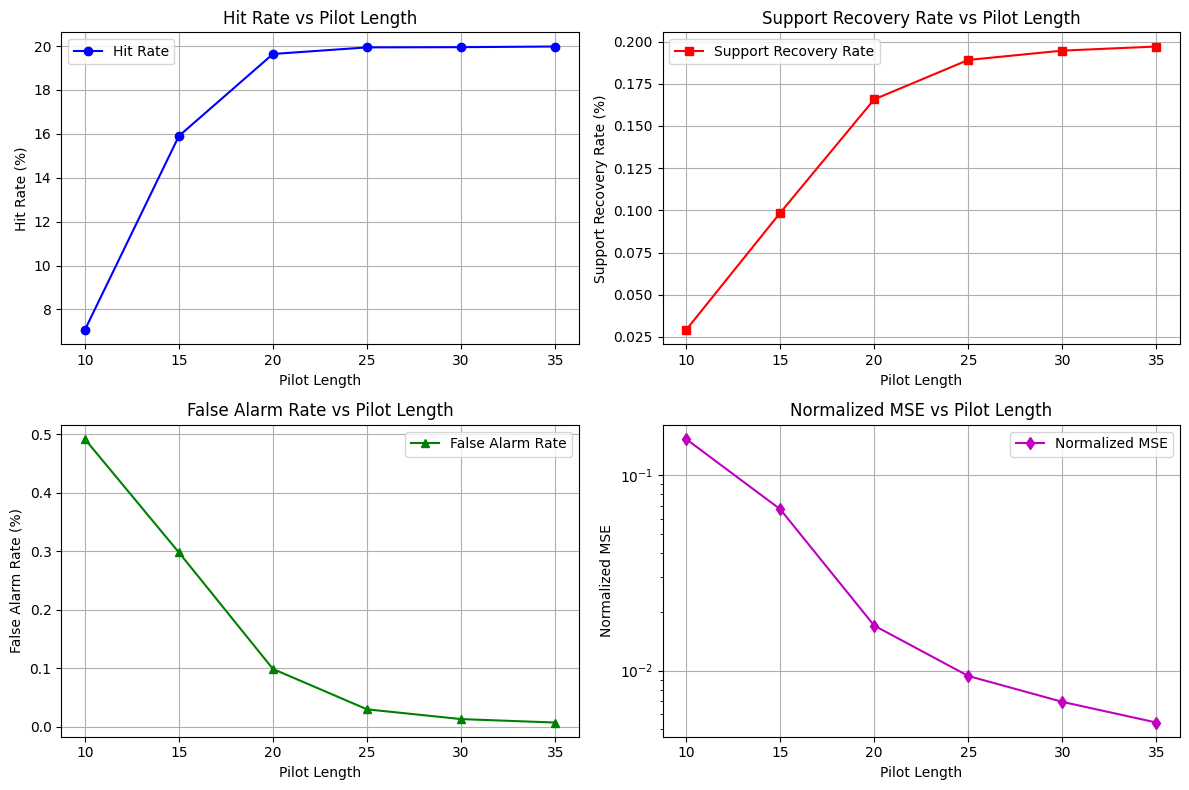

In [22]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(pilot_length_values, avg_hit_rate_sbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(pilot_length_values, avg_support_recovery_rate_sbl, marker='s', linestyle='-', color='r', label='Support Recovery Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate (%)")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(pilot_length_values, avg_false_alarm_rate_sbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(pilot_length_values, avg_norm_mse_sbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sbl_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

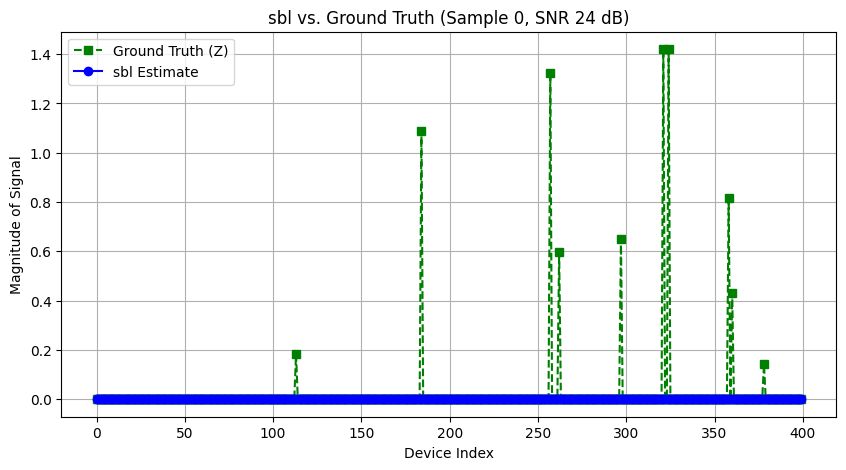

In [24]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_sbl_vs_ground_truth(z_sbl, all_z, sample_index, snr_index, snr_value)

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_sbl_vs_ground_truth(gamma_sbl, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_sbl[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


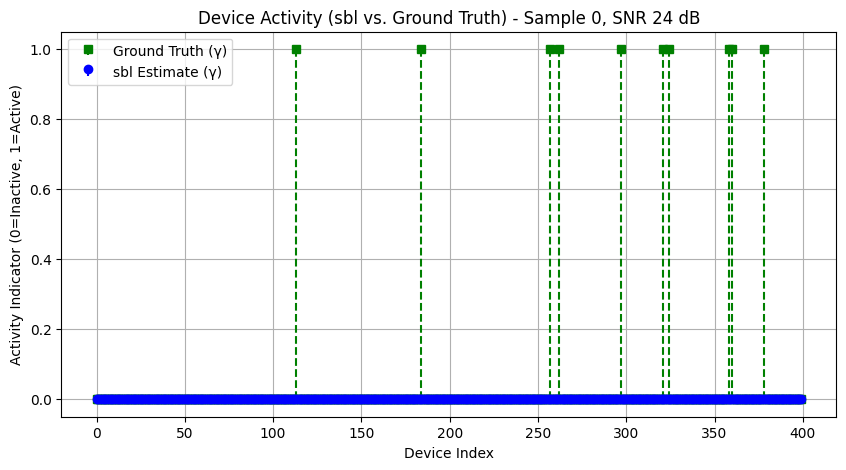

In [26]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_sbl_vs_ground_truth(gamma_sbl, all_gamma, sample_index, snr_index, snr_value)